<a href="https://colab.research.google.com/github/Rtrey29/DS-Unit-2-Linear-Models/blob/master/module3-understanding-linear-regression/Understanding_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import category_encoders as ce

In [2]:
!pip install category_encoders

In [0]:
# import the data

WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/nyc/nyc-rent-2016.csv'

df = pd.read_csv(WEB)
assert df.shape == (48300, 34)

In [0]:
# change 'created' string to datetime format
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)

In [0]:
# create a month feature using the month portion of created datetime
df['month'] = df['created'].dt.month

In [0]:
# Does apartment have a non-empty description?
df['description'] = df['description'].str.strip().fillna('')
df['has_description'] = df['description'] != ''

# How long is the description?
df['description_length'] = df['description'].str.len()

# Are pets allowed?
df['pets_allowed'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)



In [71]:
# Train/Test split
test = df.query('month == 6')
train = df.query('month <6')
train.shape, test.shape, df.shape

((31515, 39), (16785, 39), (48300, 39))

In [72]:
# Baseline for regression
# train['price'].mean()
y_test = test['price']
y_pred = [train['price'].mean()] * len(test)

mean_absolute_error(y_test, y_pred)

1052.6798017842948

In [148]:
features = ['bedrooms', 'bathrooms', 'dishwasher', 'doorman', 'balcony', 
            'fitness_center', 'laundry_in_unit','dining_room','longitude', 'roof_deck', 
            'pets_allowed','pre-war','has_description', 
            'description_length','interest_level']
target = 'price'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names = True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train) 


more = ['interest_level_2', 'interest_level_3']
features.extend(more)
print('\nIntercept', model.intercept_)

print('\nCoefficients:\n', pd.Series(model.coef_, features))




Intercept 3432.75341900693

Coefficients:
 bedrooms              546.748763
bathrooms             527.206669
dishwasher             33.554492
doorman               231.840073
balcony                -0.590808
fitness_center          8.877012
laundry_in_unit       116.212425
dining_room            21.527601
longitude            -360.751796
roof_deck             -69.087276
pets_allowed           21.397718
pre-war               -32.200526
has_description       -66.518634
description_length      6.745922
interest_level       -109.116132
interest_level_2      129.928591
interest_level_3      -72.693050
dtype: float64


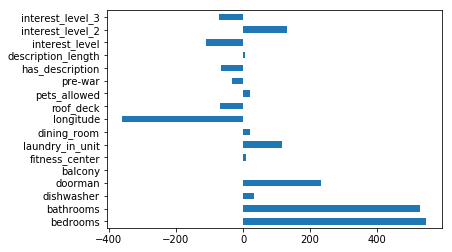

In [150]:
pd.Series(model.coef_, features).plot.barh()

plt.show()

In [142]:
print('Test Mean Absolute Error Test:', mean_absolute_error(y_test, y_pred))
print('Test Mean Absolute Error Train:', mean_absolute_error(y_train, y_train_pred))

print('\nMean Squared Error Test:', mean_squared_error(y_test, y_pred))
print('Mean Squared Error Train:', mean_squared_error(y_train, y_train_pred))

print('\nRoot Mean Squared Error Test:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error Train:', np.sqrt(mean_squared_error(y_train, y_train_pred)))

print('\nR^2 Test:', r2_score(y_test, y_pred))
print('R^2 Train:', r2_score(y_train, y_train_pred))



Test Mean Absolute Error Test: 596.0612372269521
Test Mean Absolute Error Train: 584.637098651503

Mean Squared Error Test: 718154.0019512573
Mean Squared Error Train: 679364.5317508498

Root Mean Squared Error Test: 847.4396745204093
Root Mean Squared Error Train: 824.2357258399139

R^2 Test: 0.6371990287764795
R^2 Train: 0.6526029609069661


In [185]:
# COPY
features = ['bedrooms', 'bathrooms']
target = 'price'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('\nIntercept', model.intercept_)

print('\nCoefficients:\n', pd.Series(model.coef_, features))


Intercept 3432.7534190068222

Coefficients:
 bedrooms     466.341163
bathrooms    643.028498
dtype: float64


In [0]:
# https://stackoverflow.com/a/47230966
# Plotly notebook mode with google colaboratory
# You need to define this function
# And call it in each offline plotting cell

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [183]:
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def viz3D(fitted_model, X, features, target='', num=100):
    """
    Visualize model predictions in 3D, for regression model fit on 2 features
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 features
    target : string, name of target
    num : int, number of grid points for each feature
    
    References
    ----------
    https://plot.ly/python/3d-charts/
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(min2, max2, num)
    combos = list(itertools.product(x1, x2))
    Z = fitted_model.predict(combos).reshape(num, num)
    
    configure_plotly_browser_state()
    data = [go.Surface(x=x1, y=x2, z=Z)]
    layout = go.Layout(
        scene={'xaxis': {'title': feature1, 'range': [min1,max1], 'showticklabels': True}, 
               'yaxis': {'title': feature2, 'range': [min2,max2], 'showticklabels': True}, 
               'zaxis': {'title': target, 'showticklabels': True}}, 
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [0]:
dfc =pd.DataFrame(X_train, columns =features)

In [188]:
viz3D(model, dfc, features, target ='price', num=100)